In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from scipy.interpolate import interp1d

In [2]:
ids = [10, 160, 426, 546, 814, 948, 1206, 1588, 1698, 1956, 2090, 2224, \
       2358, 2492, 2626, 2760, 2894, 3028, 3412, 3538, 3664, 3790]

ids = [426]

files = map(open, [ glob.glob("../Dataset/Mahnob/data/Sessions/{}/*.tsv".format(_id))[0] for _id in ids])

In [3]:
# exclude read header lines
for f in files:
    for i in range(1,24): f.readline()

In [4]:
header = files[0].readline().replace('\n', '').rstrip().split('\t')
print header

['Timestamp', 'DateTimeStamp', 'DateTimeStampStartOffset', 'Number', 'GazePointXLeft', 'GazePointYLeft', 'CamXLeft', 'CamYLeft', 'DistanceLeft', 'PupilLeft', 'ValidityLeft', 'GazePointXRight', 'GazePointYRight', 'CamXRight', 'CamYRight', 'DistanceRight', 'PupilRight', 'ValidityRight', 'FixationIndex', 'GazePointX', 'GazePointY', 'Event', 'EventKey', 'Data1', 'Data2', 'Descriptor', 'StimuliName', 'StimuliID', 'MediaWidth', 'MediaHeight', 'MediaPosX', 'MediaPosY', 'MappedFixationPointX', 'MappedFixationPointY', 'FixationDuration', 'AoiIds', 'AoiNames', 'WebGroupImage', 'MappedGazeDataPointX', 'MappedGazeDataPointY', 'MicroSecondTimestamp', 'AbsoluteMicroSecondTimestamp', 'AudioSampleNumber']


In [5]:
lines = [ dict(zip(header, line.split('\t'))) for line in f.readlines() ]

In [6]:
start = [ i for i,l in enumerate(lines,1) if "MovieStart" in l["Event"] ][0]
end = [ i for i,l in enumerate(lines,1) if "MovieEnd" in l["Event"] ][0]
print start
print end

2
6310


In [7]:
lines = [ l for l in lines[start:end-1] if l["ValidityLeft"] != '' and l["ValidityRight"] != '' ]

In [8]:
not_valid_left = np.where(np.array(map(int, [l["ValidityLeft"] for l in lines ])) > 1 )
not_valid_right = np.where(np.array(map(int, [l["ValidityRight"] for l in lines[start:end-1] ])) > 1 )
print not_valid_left
print not_valid_right

(array([   0,    1,    2, ..., 5959, 5960, 5961]),)
(array([   0,    2,    3, ..., 5957, 5958, 5959]),)


In [9]:
mapped_x = np.array(map(float, [l["MappedGazeDataPointX"] for l in lines[start:end-1] ]))
mapped_x_clean = mapped_x.copy()
mapped_x_clean[not_valid_left] = np.nan
mapped_x_clean[not_valid_right] = np.nan

mapped_x_clean_interp = mapped_x_clean.copy()
nans = np.isnan(mapped_x_clean_interp)
x = lambda a: a.nonzero()[0]
mapped_x_clean_interp[nans] = np.interp(x(nans), x(~nans), mapped_x_clean_interp[~nans])

In [10]:
mapped_y = np.array(map(float, [l["MappedGazeDataPointY"] for l in lines[start:end-1] ]))
mapped_y_clean = mapped_y.copy()
mapped_y_clean[not_valid_left] = np.nan
mapped_y_clean[not_valid_right] = np.nan

mapped_y_clean_interp = mapped_y_clean.copy()
nans = np.isnan(mapped_y_clean_interp)
x = lambda a: a.nonzero()[0]
mapped_y_clean_interp[nans] = np.interp(x(nans), x(~nans), mapped_y_clean_interp[~nans])

In [11]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

x_plot = np.linspace(1, mapped_x_clean.size, mapped_x_clean.size)
nans = np.isnan(mapped_x_clean)

mapped_x_clean_no_nan = mapped_y_clean[~nans]

x_plot_nan = x_plot[nans]
x_plot_no_nan = x_plot[~nans]

X_plot = x_plot[:, np.newaxis]
X_plot_nan = x_plot_nan[:, np.newaxis]
X_plot_no_nan = x_plot_no_nan[:, np.newaxis]

model = make_pipeline(PolynomialFeatures(5), Ridge())
# fit the model using clean data
model.fit(X_plot_no_nan, mapped_x_clean_no_nan)
# predict missing data
y_plot_nan = model.predict(X_plot)

mapped_x_clean_interp_poly = mapped_x_clean.copy()
# add missing data
mapped_x_clean_interp_poly[x_plot_nan.astype(int)] = y_plot_nan[x_plot_nan.astype(int)]

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.883319e-41
  overwrite_a=True).T


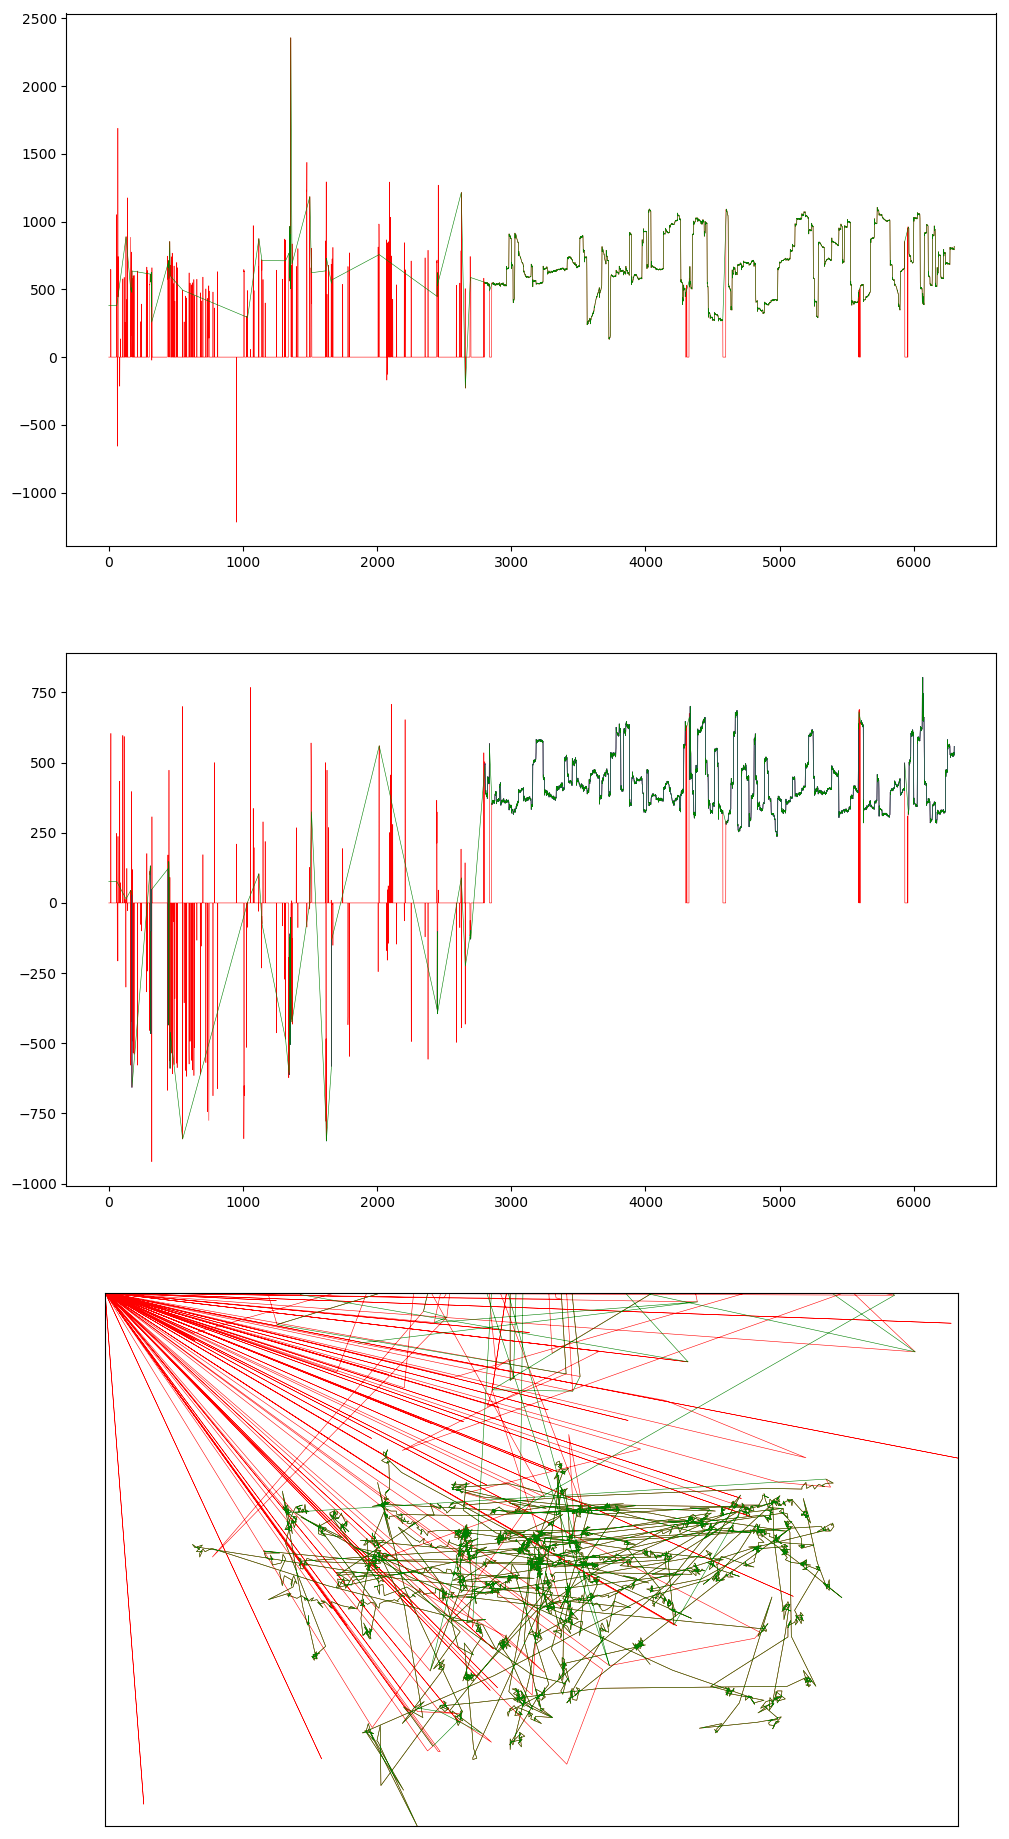

In [12]:
dpi = 100

ncols=1
nrows=3

# determine the figure size in inches
figsize = (1280*ncols/dpi, 800*nrows/dpi)

c = start
cc = end
a = c
b = c + cc

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)
axes[0].plot(mapped_x[a:b], "r", linewidth=.4, markersize=.4)
#axes[0].plot(mapped_x_clean[a:b], "b", linewidth=.4, markersize=.4)
axes[0].plot(mapped_x_clean_interp[a:b], "g", linewidth=.4, markersize=.4)
#axes[0].plot(mapped_x_clean_interp_poly[a:b], "k", linewidth=.4, markersize=.4)

axes[1].plot(mapped_y[a:b], "r", linewidth=.4, markersize=.4)
axes[1].plot(mapped_y_clean[a:b], "b", linewidth=.4, markersize=.4)
axes[1].plot(mapped_y_clean_interp[a:b], "g", linewidth=.4, markersize=.4)

axes[2].plot(mapped_x[a:b], mapped_y[a:b], "r", linewidth=.4, markersize=.4)
axes[2].plot(mapped_x_clean_interp[a:b], mapped_y_clean_interp[a:b], "g", linewidth=.4, markersize=.4)
axes[2].axis([0, 1280, 0, 800])
axes[2].set_aspect(8/5)
axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
axes[2].invert_yaxis()

plt.show()